In [233]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import store_bin, project_dir, data_files, load_csv, load_bin, write_xlsx
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect, value, flatten, normalize_rows
from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [6]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_struct = load_bin("ax_var_struct.feather")

In [89]:
Variable = namedtuple("Variable", ["Label", "Codes"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(data["Variable_Label"].max(), data["Label"].to_list())

In [28]:
def var_label(variable):
    return var_info[variable].Label


def var_codes(variable):
    return var_info[variable].Codes

In [361]:
weekday_order = ax_data["DayOfWeek"].cat.categories.to_list()
timeSlot_order = ax_data["TimeSlot"].cat.categories.to_list()

with value(ax_data["DayOfWeek"].isin(["Saturday", "Sunday"])) as weekend_rows:
    ax_data_weekends = ax_data.loc[weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)
    ax_data_workdays = ax_data.loc[~weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)

In [362]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/6172735,27,5.9 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/6172735,7,5.9 MB,"[Monday,Sunday]"
Time,category,0/6172735,96,5.9 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/6172735,117,5.9 MB,"[g_220,nat_ausland]"
Code,category,0/6172735,155,11.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/6172735,343130,47.1 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/6172735,1,5.9 MB,"[2019,2019]"
Month,category,0/6172735,4,5.9 MB,"[05,08]"
logValue,float64,0/6172735,343130,47.1 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,170487/6002248,114,5.9 MB,"[nan,kein Mobiltelefon]"


In [363]:
desc_col(ax_data_workdays, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/4515721,27,4.3 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/4515721,5,4.3 MB,"[Monday,Friday]"
Time,category,0/4515721,96,4.3 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/4515721,117,4.3 MB,"[g_220,nat_ausland]"
Code,category,0/4515721,154,8.6 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/4515721,292163,34.5 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/4515721,1,4.3 MB,"[2019,2019]"
Month,category,0/4515721,4,4.3 MB,"[05,08]"
logValue,float64,0/4515721,292163,34.5 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,124362/4391359,114,4.3 MB,"[nan,kein Mobiltelefon]"


In [364]:
desc_col(ax_data_weekends, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/1657014,27,1.6 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/1657014,2,1.6 MB,"[Saturday,Sunday]"
Time,category,0/1657014,96,1.6 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/1657014,117,1.6 MB,"[g_220,nat_ausland]"
Code,category,0/1657014,154,3.2 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/1657014,74445,12.6 MB,"[0.47903999999999997,30.32099024]"
Year,category,0/1657014,1,1.6 MB,"[2019,2019]"
Month,category,0/1657014,4,1.6 MB,"[05,08]"
logValue,float64,0/1657014,74445,12.6 MB,"[-0.7359711777508736,3.4118402198714635]"
VarDesc,category,46125/1610889,114,1.6 MB,"[nan,kein Mobiltelefon]"


## Define code order, where necessary

In [32]:
var_code_ordered = {
    "md_agenatrep": {
        "14-29 Jahre": 1,
        "30-45 Jahre": 2,
        "46-60 Jahre": 3,
        "61+ Jahre": 4,
    },
    "md_bildung3": {
        "niedrig (kein Abschluss, obligat. Schule, HH-Lehrjahr, Handelsschule, Anlehre)": 1,
        "mittel (Diplommittelschule, allg. Schule, Berufslehre, Vollzeitberufsschule, Maturität, Lehrerseminar)": 2,
        "hoch (Universität, ETH, FH, PH, höhere Berufsausbildung)": 3,
    },
    "md_hhgr3": {"1 Person": 1, "2 Personen": 2, "3+ Personen": 3},
    "g_privatetrainuse": {
        "Nie": 1,
        "1-2 Mal jährlich": 2,
        "3-12 Mal jährlich": 3,
        "2-5 Mal pro Monat": 4,
        "6 Mal pro Monat oder häufiger": 5,
    },
    "md_203": {  # Bahnnutzung beruflich
        "Nie": 1,
        "Seltener": 2,
        "Etwa zu einem Viertel": 3,
        "Etwa zur Hälfte": 4,
        "Meistens": 5,
        "Immer": 6,
    },
    "g_220": {  # Autos im Haushalt
        "Keines": 1,
        "1 Auto": 2,
        "2 Autos": 3,
        "3 Autos": 4,
        "Mehr als 3 Autos": 5,
    },
    "md_410": {  # Internetnutzung
        "seltener": 1,
        "mehrmals pro Monat": 2,
        "einmal pro Woche": 3,
        "mehrmals pro Woche": 4,
        "täglich/fast täglich": 5,
    },
    # Div.Internet-Nutzungsarten (md_421 bis md_411)
    "md_421": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_419": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_417": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_416": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_415": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_414": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_413": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_412": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_411": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_early": {
        "Ich bin immer einer/eine der ersten, der/die neue Technologien und Geräte kauft resp. einsetzt.": 1,
        "Ich fange erst dann an, neue Technologien und Geräte zu verwenden, wenn ich weiss, welche Erfahrungen andere mit ihnen gemacht haben.": 2,
        "Ich übernehme neue Technologien und Geräte erst dann, wenn es für mich persönlich oder beruflich unerlässlich ist.": 3,
    },
    "md_tv": {"kein TV-Gerät": 1, "1 oder mehrere TV-Geräte": 2},
    "g_TvChannelsgroup": {
        "keine Sender": 1,
        "1-4 Sender": 2,
        "5-9 Sender": 3,
        "10++ Sender": 4,
    },
    "g_flug": {"keine Flüge": 1, "1 - 4 Flüge": 2, "5 - 9 Flüge": 3, "10++ Flüge": 4},
    "g_flugBusiness": {
        "keine Flüge": 1,
        "1 - 4 Flüge": 2,
        "5 - 9 Flüge": 3,
        "10++ Flüge": 4,
    },
    "md_ek": {
        "Keine Angabe": 0,
        "Weniger als 3'000 CHF": 1,
        "Zwischen 3'000 und 4'500 CHF": 2,
        "Zwischen 4'501 und 6'000 CHF": 3,
        "Zwischen 6'001 und 9'000 CHF": 4,
        "Zwischen 9'001 und 12'000 CHF": 5,
        "Mehr als 12'000 CHF": 6,
    },
    "md_hhverm": {
        "Keine Angabe": 0,
        "Weniger als CHF 50 000": 1,
        "Zwischen CHF 50 000 und CHF 100 000": 2,
        "Zwischen CHF 100 000 und CHF 250 000": 3,
        "Zwischen CHF 250 000 und CHF 500 000": 4,
        "Zwischen CHF 500 000 und CHF 1 Mio.": 5,
        "Zwischen CHF 1 Mio. und CHF 5 Mio.": 6,
        "Mehr als CHF 5 Mio.": 7,
    },
}

# Check distributions

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Time

In [ ]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"), # average workday
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"), # average weekend day
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_weekend,
)
fig.autofmt_xdate(rotation=90, ha="left")

### Time by Weekday

In [ ]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Hours

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),  # average workday
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),  # average weekend day
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)

## Time Slots

In [ ]:
ax_data["TimeSlot"].value_counts()

### Plot sum(value) per time slot, scaled to one day

In [ ]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(10, 12)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)

## Stations

In [ ]:
ax_data.Station.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

## Weekdays

In [ ]:
ax_data.DayOfWeek.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

## Months

In [ ]:
ax_data.Month.value_counts()

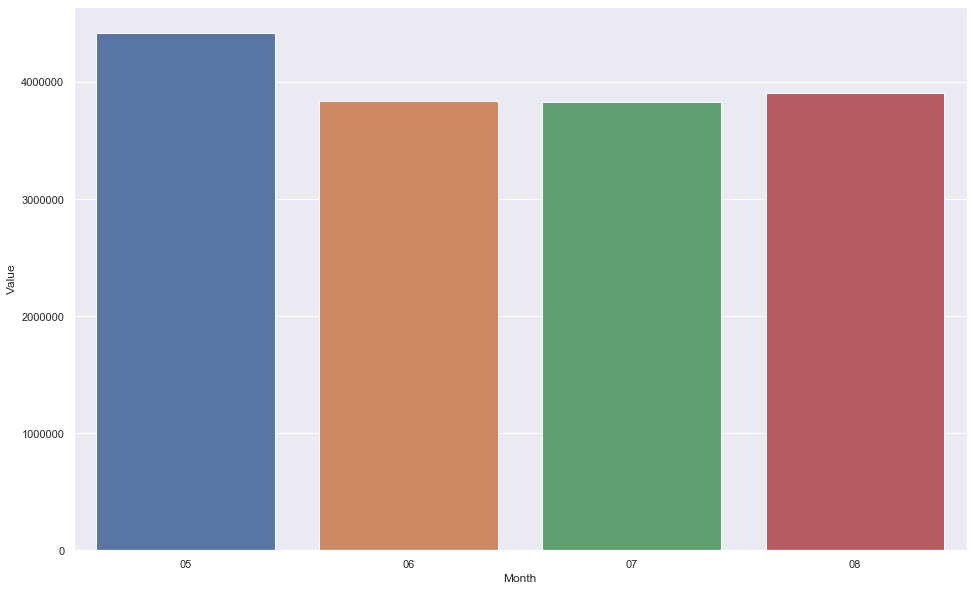

In [365]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="Month",
    y="Value",
    estimator=np.sum,
    ci=None
);

## Variables (Questions)

In [ ]:
ax_data.Variable.value_counts()

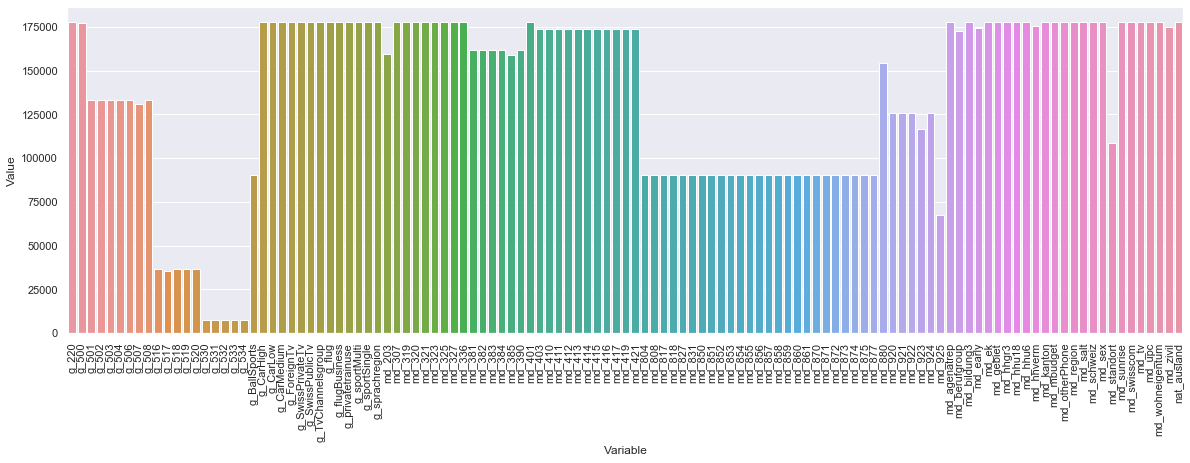

In [228]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

sns.barplot(
    data=ax_data,
    x="Variable",
    y="Value",
    estimator=np.sum,
    ci=None,
);

# Tests for Independence

In [369]:
from scipy.stats import chi2_contingency


def _var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result


def factor_dependance(data, factor, partitions):
    all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for v in var_info.keys():
        var_assoc = _var_factor_dependance(
            data=data, variable=v, factor=factor, partitions=partitions
        ).query(f"p_{factor} <= 0.05")
        all_var_assoc = all_var_assoc.append(var_assoc, ignore_index=True, sort=False)
    all_var_assoc["VarDesc"] = all_var_assoc["Var"].apply(var_label)
    return all_var_assoc

## For all variables, find stations where the distribution of codes is dependent on day time / time slot

In [ ]:
%%time
all_var_assoc_time = factor_dependance(
    data=ax_data, factor="Time", partitions=["Station"]
)
all_var_assoc_timeslot = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station"]
)

In [ ]:
var_stations_time = pd.crosstab(
    index=all_var_assoc_time["VarDesc"].str.cat(all_var_assoc_time["Var"], sep=" [")
    + "]",
    columns=all_var_assoc_time["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_time, "var_by_station_vs_time.xlsx", sheet_name="contigency tab"
    )

In [ ]:
var_stations_timeslot = pd.crosstab(
    index=all_var_assoc_timeslot["VarDesc"].str.cat(
        all_var_assoc_timeslot["Var"], sep=" ["
    ) + ']',
    columns=all_var_assoc_timeslot["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_timeslot,
        "var_by_station_vs_timeslot.xlsx",
        sheet_name="contigency tab",
    )

### Which variables have the most stations where their codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Var", as_index=False).agg(
    {"VarDesc": "max", "Label": ["count", collect]}
).set_axis(
    ["Variable", "VarDesc", "#", "Stations"], axis="columns", inplace=False
).sort_values(
    "#", ascending=False
).set_index(
    "Variable"
)

### Which stations have the most variables whose codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Label", as_index=False).agg(
    {"Var": ["size", collect]}
).set_axis(["Station", "#", "Variables"], axis="columns", inplace=False).sort_values(
    "#", ascending=False
).set_index(
    "Station"
)

## For a single variable, show distribution of codes over time

In [37]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)

time_order = {"DayOfWeek": weekday_order, "TimeSlot": timeSlot_order}

def plot_var_time_dist(data, variable, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @variable")
        .pipe(clean_up_categoricals)
        .copy()
    )
    codes_sorted = variable in var_code_ordered
    if codes_sorted:
        subset["Code_order"] = subset["Code"].replace(var_code_ordered[variable])
        code_list_sorted = list(var_code_ordered[variable])
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(
                over,
                sort=time_order.get(over, "ascending"),
            ),
            color=alt.Color(
                "Code",
                sort=code_list_sorted if codes_sorted else "ascending",
                scale=alt.Scale(scheme="spectral" if codes_sorted else "category20"),
            ),
            order=alt.Order("Code_order") if codes_sorted else alt.Order("Code"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(variable)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

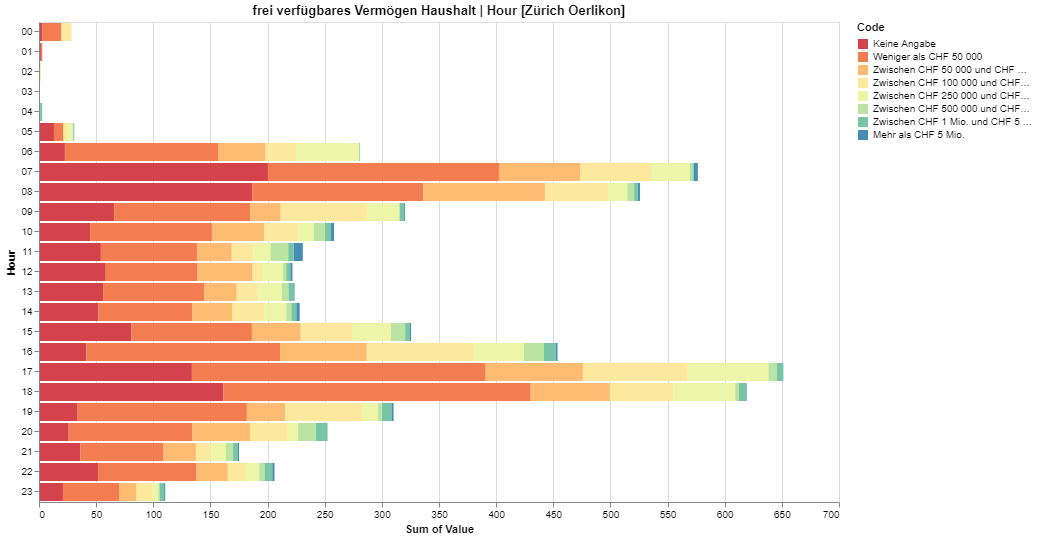

In [38]:
plot_var_time_dist(
    data=ax_data_workdays,
    variable=var.md_hhverm,
    over="Hour",
    station="Zürich Oerlikon",
    as_percent=False,
)

## Does time-dependance of variables change between months?

In [371]:
%%time
all_var_assoc_timeslot_month = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station", "Month"]
)

In [372]:
pd.crosstab(
    index=all_var_assoc_timeslot_month["Var"],
    columns=all_var_assoc_timeslot_month["Label"],
)

Label,"(Aarau, 05)","(Aarau, 06)","(Aarau, 07)","(Aarau, 08)","(Basel SBB, 05)","(Basel SBB, 06)","(Basel SBB, 07)","(Basel SBB, 08)","(Bellinzona, 05)","(Bellinzona, 06)","(Bellinzona, 07)","(Bellinzona, 08)","(Bern, 05)","(Bern, 06)","(Bern, 07)","(Bern, 08)","(Biel/Bienne, 05)","(Biel/Bienne, 06)","(Biel/Bienne, 07)","(Biel/Bienne, 08)","(Brig, 05)","(Brig, 06)","(Brig, 07)","(Brig, 08)","(Chur, 05)","(Chur, 06)","(Chur, 07)","(Chur, 08)","(Fribourg, 05)","(Fribourg, 06)","(Fribourg, 07)","(Fribourg, 08)","(Genève Aéroport, 05)","(Genève Aéroport, 06)","(Genève Aéroport, 07)","(Genève Aéroport, 08)","(Genève Cornavin, 05)","(Genève Cornavin, 06)","(Genève Cornavin, 07)","(Genève Cornavin, 08)","(Lausanne, 05)","(Lausanne, 06)","(Lausanne, 07)","(Lausanne, 08)","(Lugano, 05)","(Lugano, 06)","(Lugano, 07)","(Lugano, 08)","(Luzern, 05)","(Luzern, 06)","(Luzern, 07)","(Luzern, 08)","(M2, 07)","(M2, 08)","(Neuchatel, 05)","(Neuchatel, 06)","(Neuchatel, 07)","(Neuchatel, 08)","(Olten, 05)","(Olten, 06)","(Olten, 07)","(Olten, 08)","(St. Gallen, 05)","(St. Gallen, 06)","(St. Gallen, 07)","(St. Gallen, 08)","(Winterthur, 05)","(Winterthur, 06)","(Winterthur, 07)","(Winterthur, 08)","(Zug, 05)","(Zug, 06)","(Zug, 07)","(Zug, 08)","(Zürich Enge, 05)","(Zürich Enge, 06)","(Zürich Enge, 07)","(Zürich Enge, 08)","(Zürich Flughafen, 05)","(Zürich Flughafen, 06)","(Zürich Flughafen, 07)","(Zürich Flughafen, 08)","(Zürich Flughafen - Airside, 08)","(Zürich Flughafen - Landside, 08)","(Zürich HB, 05)","(Zürich HB, 06)","(Zürich HB, 07)","(Zürich HB, 08)","(Zürich Hardbrücke, 05)","(Zürich Hardbrücke, 06)","(Zürich Hardbrücke, 07)","(Zürich Hardbrücke, 08)","(Zürich Oerlikon, 05)","(Zürich Oerlikon, 06)","(Zürich Oerlikon, 07)","(Zürich Oerlikon, 08)","(Zürich Stadelhofen, 05)","(Zürich Stadelhofen, 06)","(Zürich Stadelhofen, 07)","(Zürich Stadelhofen, 08)"
Var,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
g_220,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
g_500,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
g_501,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0
g_502,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g_503,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
g_504,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,1
g_506,1,0,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
g_507,1,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,0,1,1,1,0,0,1,1,0,1,0,1
g_508,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,1,1,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,0,0,1,0,0,0,1,0,1,0


# ANOVA

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [ ]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov["mean_sq"] = aov[:]["sum_sq"] / aov[:]["df"]
    aov["eta_sq"] = aov[:-1]["sum_sq"] / sum(aov["sum_sq"])
    aov["omega_sq"] = (aov[:-1]["sum_sq"] - (aov[:-1]["df"] * aov["mean_sq"][-1])) / (
        sum(aov["sum_sq"]) + aov["mean_sq"][-1]
    )
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]
    return aov


def calc_anova(data, variable, formula="logValue ~ Code + Station + DayOfWeek"):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    subset = subset.assign(
        label=subset.Station.str.cat([subset.DayOfWeek.str[:3], subset.Code], sep="|")
    )
    subset.set_index("label", inplace=True)
    mod = smf.ols(formula=formula, data=subset)
    res = mod.fit()
    print(f"Variable: {var_label(variable)}")
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())


def anova_stats(data, variable):
    """ANOVA statistics"""
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)

    lm_base = smf.ols(formula="logValue ~ Code:TimeSlot:DayOfWeek", data=subset).fit()
    lm_base_station = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station", data=subset
    ).fit()
    lm_base_station_month = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station + Month", data=subset
    ).fit()
    return {
        "var": variable,
        "base": lm_base.rsquared,
        "base+station": lm_base_station.rsquared,
        "base+station+month": lm_base_station_month.rsquared,
    }

In [ ]:
calc_anova(ax_data_workdays, var.g_220, formula='logValue ~ Code:TimeSlot:DayOfWeek + Station + Month')

In [ ]:
%%time
all_var_stats = pd.DataFrame.from_records(
    columns="var base base+station base+station+month".split(),
    data=[anova_stats(ax_data_workdays, v) for v in var.keys()],
    index="var",
)

all_var_stats = all_var_stats.assign(
    **{
        "plus_station": all_var_stats["base+station"] - all_var_stats["base"],
        "plus_month": all_var_stats["base+station+month"]
        - all_var_stats["base+station"],
        "plus_station_month": all_var_stats["base+station+month"]
        - all_var_stats["base"],
    }
)

In [ ]:
all_var_stats.sort_values("base+station+month", ascending=False).loc[
    :, "base plus_station plus_month base+station+month".split()
]

# Estimation and Confidence Intervals for Target Groups

## Select data by any column(s)

In [346]:
def _check_selection(data, selection):
    select_columns = "DayOfWeek Station Variable Month TimeSlot Hour Time".split()
    values = {}
    for column in select_columns:
        values[column] = data[column].cat.categories
    if set(selection.keys()) - set(select_columns) != set():
        raise NameError(f"Unknown column name in selection: {selection.keys()}")
    clean_sel = {}
    for col in select_columns:
        if col in selection:
            col_values = list(flatten(selection[col]))
            if set(col_values) - set(values[col]) != set():
                raise ValueError(f"Illegal value(s) in parameter {col}: {col_values}")
            clean_sel[col] = col_values
        else:
            clean_sel[col] = None
    return clean_sel


def select_data(all_data, **selection):
    selection = _check_selection(all_data, selection)
    row_mask = pd.Series([True] * all_data.shape[0])
    for col in select_columns:
        if selection[col] is not None:
            row_mask &= all_data[col].isin(selection[col])
    #print(row_mask.index, all_data.index)
    return all_data.loc[row_mask].pipe(clean_up_categoricals)

## Calculate code proportions

In [333]:
tmp = select_data(
    ax_data, DayOfWeek=["Saturday", "Sunday"], Station="Zürich HB", Variable=["md_ek"]
)

for var, data in tmp.groupby("Variable"):
    prop_table = data.pivot_table(
        index="Hour",
        columns="Code",
        values="Value",
        aggfunc="sum",
        margins=False,
        fill_value=0,
    )
    display(prop_table)
    display(normalize_rows(prop_table))

Code,Keine Angabe,Mehr als 12'000 CHF,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF
Hour,,,,,,,
00,22.915033,25.820109,20.850626,11.830029,14.382700,27.502084,42.820421
01,14.291338,12.342298,7.147786,12.445263,19.719465,12.972056,22.390262
02,12.076984,17.507178,5.423160,10.399585,2.846470,11.842857,11.173138
03,1.983639,5.151176,7.707317,4.488452,6.758510,1.057927,14.453337
04,0.000000,5.371758,3.374067,1.124689,1.391267,3.182678,6.099786
05,4.872562,5.699748,2.025012,0.000000,0.000000,3.775502,10.527682
06,7.806630,19.517080,2.107455,4.299383,7.071258,24.048772,26.986630
07,15.570198,52.207379,6.594864,3.366083,56.194975,42.246064,58.074653
08,33.466155,74.625581,11.257372,14.387205,59.623799,87.791978,90.704943


Code,Keine Angabe,Mehr als 12'000 CHF,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF
Hour,,,,,,,
00,0.137942,0.155430,0.125515,0.071213,0.086580,0.165555,0.257766
01,0.141068,0.121829,0.070555,0.122845,0.194648,0.128045,0.221011
02,0.169455,0.245648,0.076094,0.145919,0.039940,0.166170,0.156773
03,0.047683,0.123825,0.185270,0.107895,0.162463,0.025431,0.347433
04,0.000000,0.261473,0.164234,0.054745,0.067721,0.154918,0.296910
05,0.181133,0.211883,0.075278,0.000000,0.000000,0.140351,0.391356
06,0.085005,0.212518,0.022948,0.046815,0.076998,0.261863,0.293853
07,0.066467,0.222866,0.028153,0.014369,0.239889,0.180343,0.247913
08,0.089997,0.200684,0.030273,0.038690,0.160341,0.236091,0.243924


In [358]:
def estimate(s):
    try:
        return np.percentile(s, [5, 50, 95]).tolist()
    except:
        return -1

In [359]:
tmp = select_data(
    ax_data_weekends,
    Variable=["md_ek"],
    Station="Brig",
)

for var, data in tmp.groupby(["Variable", "DayOfWeek"]):
    prop_table = data.pivot_table(
        index="TimeSlot",
        columns="Code",
        values="Value",
        aggfunc=estimate,
        margins=False,
        fill_value=0,
    )
    display(var)
    display(prop_table)

('md_ek', 'Saturday')

Code,Keine Angabe,Mehr als 12'000 CHF,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF
TimeSlot,,,,,,,
Nacht,0,0,"[1.271737143, 1.271737143, 1.271737143]",0,0,"[1.128453061, 1.1284530609999999, 1.1284530609999999]","[0.8177, 0.8386392859999999, 0.9133913042]"
Morgen-Rush,0,"[1.0151226687000001, 1.015517073, 1.9390562499]",0,0,"[0.8419968611499999, 0.8722150375, 0.9024332138500001]","[0.892329412, 0.892329412, 0.892329412]",0
Morgen,"[0.9440243475000001, 1.2502285709999998, 2.0011841688499996]","[0.85976129, 0.931509783, 1.2689241931999993]","[1.0558790699999998, 1.05587907, 1.05587907]","[1.011073585, 1.011073585, 1.011073585]","[0.8706391666000001, 0.905595833, 1.0757373129999999]","[0.904415171, 1.1661, 2.9274666660000004]","[0.85493571425, 0.90253913, 1.819539295]"
Mittag,0,"[0.9210367092, 1.0111535310000002, 1.1012703528]",0,0,"[0.834042857, 0.834042857, 0.8381796430999999]","[0.834042857, 0.905595833, 1.0615958925999998]","[0.8340428569999999, 0.834042857, 0.834042857]"
Nachmittag,"[0.9296413040000001, 0.940625, 0.951608696]","[0.9907757712, 1.070936, 1.8555940378]","[1.1746551819, 1.62435, 1.6861123245]",0,"[0.834042857, 0.850269643, 1.517578302]","[0.86406989365, 0.920626087, 2.9602347945]","[0.834042857, 0.9706771275, 1.8338659007499998]"
Abend-Rush,"[1.164718033, 1.2502285709999998, 1.2502285709999998]","[0.970735714, 0.970735714, 0.970735714]","[0.6613725228, 1.05587907, 1.05587907]","[1.011073585, 1.011073585, 1.011073585]","[0.834042857, 0.9333, 2.4307897499999997]","[0.8552563485, 1.0043456794999999, 1.20427234]","[0.8386392859999999, 1.05315, 2.8108023365999992]"
Abend,0,"[0.9296413040000001, 1.1177315215, 1.305821739]",0,0,"[0.8485730090000001, 0.9066936170000001, 0.9066936170000002]","[0.8609435220499999, 1.295242553, 2.008691359]","[0.834042857, 0.8619, 1.2892905325]"


('md_ek', 'Sunday')

Code,Keine Angabe,Mehr als 12'000 CHF,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF
TimeSlot,,,,,,,
Nacht,0,"[0.9110237290000001, 0.9110237290000001, 0.9110237290000001]",0,0,0,0,0
Morgen-Rush,0,"[0.8690775262, 0.8915466670000001, 0.9907229918000001]",0,0,0,"[0.931509783, 0.931509783, 0.931509783]","[0.834618293, 0.834618293, 0.834618293]"
Morgen,0,"[0.863460241, 0.863460241, 0.863460241]","[1.0558790699999998, 1.05587907, 1.05587907]","[0.880238298, 0.880238298, 0.880238298]","[0.9154547475999999, 1.064328604, 1.2132024604]","[0.8200433729999999, 0.881507401, 0.9429714290000001]","[0.834042857, 0.841028571, 0.8801576472]"
Mittag,0,"[0.841028571, 0.841028571, 0.841028571]","[1.0558790699999998, 1.05587907, 1.05587907]","[1.011073585, 1.011073585, 1.011073585]",0,"[0.8345170997, 0.838785284, 0.8430534682999999]",0
Nachmittag,0,"[0.8953561307000002, 0.9296413040000001, 0.9296413040000001]","[1.0629267665, 1.124689091, 1.124689091]",0,"[0.84379285705, 0.8619, 1.4350896227999996]","[0.841028571, 0.8956310135000001, 1.261542857]","[0.820043373, 0.880238298, 1.6962550504]"
Abend-Rush,0,"[0.969351724, 0.9924343985, 1.3349042278999996]","[1.052128814, 1.052128814, 1.052128814]",0,"[0.8349621428, 0.898913208, 1.6180437743999998]","[0.823543244, 0.842784159, 0.888204255]","[0.81379726, 0.898913208, 4.202753572]"
Abend,"[0.90576, 0.90576, 1.3556182499999996]","[0.9057907890000001, 1.126045283, 1.22856444575]","[0.6170450496, 1.05587907, 1.0560457643999999]",0,"[1.046214, 1.046214, 1.046214]","[0.8227997685, 0.888204255, 1.8303957345000001]","[0.779497143, 0.841028571, 0.920626087]"
